In [1]:
#Import the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, mean_squared_error

from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
S_Data = pd.read_csv('ED-sepsis.csv')
death = S_Data.death
S_Data.head()

,No,EDTime,gender,WHITE,WHITE - RUSSIAN,WHITE - EASTERN EUROPEAN,WHITE - OTHER EUROPEAN,WHITE - BRAZILIAN,SOUTH AMERICAN,ASIAN,...,temperature,heartrate,resprate,o2sat,sbp,dbp,qsofa,HospTime,death,EDTime_grp
0,1,0.127431,0,1,0,0,0,0,0,0,...,0.527397,0.664706,0.500000,0.986667,0.442105,0.383333,0.333333,5.838889,0,3
1,2,0.091591,1,0,0,0,1,0,0,0,...,0.547945,0.758824,0.434783,1.000000,0.526316,0.500000,0.333333,8.860417,0,2
2,3,0.101736,1,1,0,0,0,0,0,0,...,0.486301,0.482353,0.413043,0.966667,0.389474,0.283333,0.000000,10.704861,0,2
3,4,0.070833,0,0,0,0,0,0,0,0,...,0.493151,0.294118,0.086957,0.966667,0.421053,0.583333,0.000000,14.060417,0,2
4,5,0.102778,1,1,0,0,0,0,0,0,...,0.678082,0.776471,0.608696,0.946667,1.000000,0.800000,0.666667,10.531250,0,2


In [3]:
#Split data to training and validation
X_train, X_val, Y_train, Y_val = train_test_split(S_Data, death, stratify=death, test_size=0.2, random_state = 42)

In [4]:
#Create second dataset for 28-days mortality
X_train_28 = X_train.copy()
X_train_28.loc[X_train_28.HospTime > 28, 'death'] = 0

X_val_28 = X_val.copy()
X_val_28.loc[X_val_28.HospTime > 28, 'death'] = 0

In [5]:
Y_train = X_train[['EDTime', 'EDTime_grp', 'No','HospTime', 'death']].copy()

X_train.drop(['EDTime'], axis=1, inplace= True)
X_train.drop(['EDTime_grp'], axis=1, inplace= True)
X_train.drop(['No'], axis=1, inplace= True)
X_train.drop(['HospTime'], axis=1, inplace= True)
X_train.drop(['death'], axis=1, inplace= True)

Y_val = X_val[['EDTime', 'EDTime_grp', 'No','HospTime', 'death']].copy()

X_val.drop(['EDTime'], axis=1, inplace= True)
X_val.drop(['EDTime_grp'], axis=1, inplace= True)
X_val.drop(['No'], axis=1, inplace= True)
X_val.drop(['HospTime'], axis=1, inplace= True)
X_val.drop(['death'], axis=1, inplace= True)

Y_train_28 = X_train_28[['EDTime', 'EDTime_grp', 'No','HospTime', 'death']].copy()
Y_val_28 = X_val_28[['EDTime', 'EDTime_grp', 'No','HospTime', 'death']].copy()

In [6]:
#PCA will reset the index. So, reset the index as well so we can match them afterwards.
X_train.reset_index(drop = True, inplace = True)
X_val.reset_index(drop = True, inplace = True)

Y_train.reset_index(drop = True, inplace = True)
Y_val.reset_index(drop = True, inplace = True)
Y_train_28.reset_index(drop = True, inplace = True)
Y_val_28.reset_index(drop = True, inplace = True)

# Feature Selection

### No Feature Selection

In [7]:
NFS_X_train = X_train.copy()
NFS_X_val = X_val.copy()

### PCA

In [8]:
pca = PCA()
PCA_X_train = pca.fit_transform(X_train)
PCA_variance = pca.explained_variance_ratio_

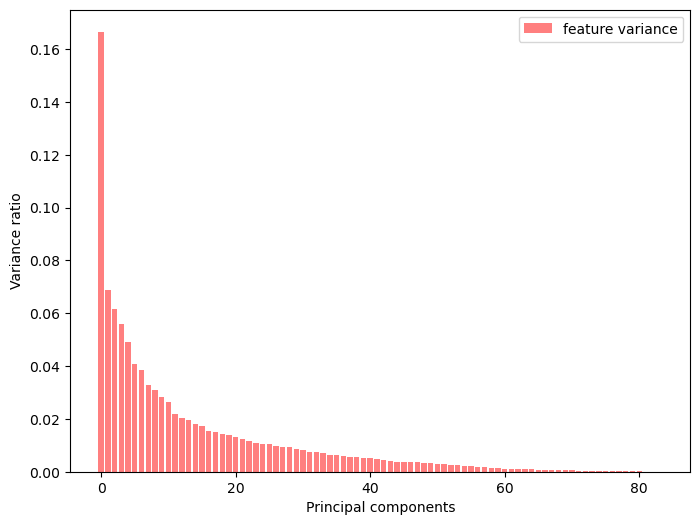

In [9]:
plt.figure(figsize=(8, 6))
plt.bar(range(84), PCA_variance, alpha=0.5, label='feature variance', color = 'red')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

In [10]:
#Choose the number of variables so that the explained variance is at least 95%.
var_exp = 0
for i in range(84):
    var_exp = var_exp + PCA_variance[i]
    if var_exp >= 0.95:
        num_var = i + 1
        break
print('To explain 95% of the data, we need ' + str(num_var) + ' variables from PCA.')

To explain 95% of the data, we need 46 variables from PCA.


In [11]:
pca95 = PCA(n_components = num_var)
pca95 = pca95.fit(X_train)

In [12]:
PCA_X_train = pd.DataFrame(pca95.transform(X_train))
PCA_X_val = pd.DataFrame(pca95.transform(X_val))

### SPCA

In [13]:
spa = SparsePCA()
SPA_X_train = spa.fit_transform(X_train)
SPA_variance = np.var(SPA_X_train, axis=0)
SPA_variance = SPA_variance / np.sum(SPA_variance)
SPA_variance = -np.sort(-SPA_variance)

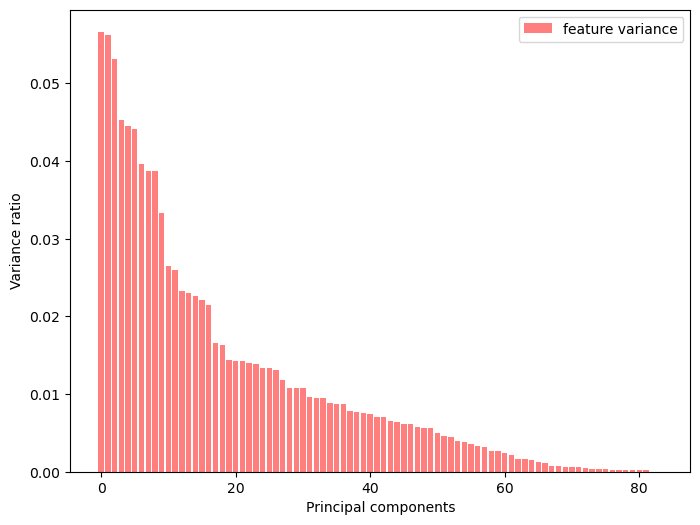

In [14]:
plt.figure(figsize=(8, 6))
plt.bar(range(84), SPA_variance, alpha=0.5, label='feature variance', color = 'red')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

In [15]:
#Choose the number of variables so that the explained variance is at least 95%.
var_exp = 0
for i in range(84):
    var_exp = var_exp + SPA_variance[i]
    if var_exp >= 0.95:
        num_var = i + 1
        break
print('To explain 95% of the data, we need ' + str(num_var) + ' variables from PCA.')

To explain 95% of the data, we need 52 variables from PCA.


In [16]:
spa95 = SparsePCA(n_components=num_var)
spa95 = spa95.fit(X_train)

In [17]:
SPA_X_train = pd.DataFrame(spa95.transform(X_train))
SPA_X_val = pd.DataFrame(spa95.transform(X_val))

### Simple Logistic Regression
We will perform a simple logistic regression using all the columns provided.<br>

In [18]:
def LogR(X_train, Y_train, X_val, Y_val):
    #Train the logistic regression model
    LogR = LogisticRegression()
    LogR.fit(X_train, Y_train)
    Y_hat_train = LogR.predict(X_train)
    Y_hat_val = LogR.predict(X_val)
    
    #classificiation report on the training and the validation set
    Cl_Rep_tr = classification_report(Y_train, Y_hat_train)
    print("Classification Report on the Training Set")
    print(Cl_Rep_tr)
    Cl_Rep_val = classification_report(Y_val, Y_hat_val)
    print("\nClassification Report on the Validation Set")
    print(Cl_Rep_val)
    
    #Below is the coefficient of the trained logistic regression model
    LogR_coef = pd.DataFrame(zip(X_train.columns, np.transpose(LogR.coef_)), columns=['features', 'coef'])
    print(LogR_coef.loc[LogR_coef['features'] == 'EDTime'])
    
    return LogR_coef

### Logistic Regression: No Feature Selection

In [19]:
NFS_X_train.insert(0, 'EDTime', Y_train['EDTime'])
NFS_X_val.insert(0, 'EDTime', Y_val['EDTime'])

In [20]:
LogR_NFS_coef = LogR(NFS_X_train, Y_train.death, NFS_X_val, Y_val.death)

Classification Report on the Training Set
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1458
           1       0.68      0.27      0.39       257

    accuracy                           0.87      1715
   macro avg       0.78      0.62      0.66      1715
weighted avg       0.85      0.87      0.85      1715


Classification Report on the Validation Set
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       365
           1       0.64      0.28      0.39        64

    accuracy                           0.87       429
   macro avg       0.76      0.63      0.66       429
weighted avg       0.85      0.87      0.85       429

  features                   coef
0   EDTime  [0.25412063671385093]


In [21]:
LogR_NFS_coef_28 = LogR(NFS_X_train, Y_train_28.death, NFS_X_val, Y_val_28.death)

Classification Report on the Training Set
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1465
           1       0.69      0.27      0.39       250

    accuracy                           0.88      1715
   macro avg       0.79      0.63      0.66      1715
weighted avg       0.86      0.88      0.85      1715


Classification Report on the Validation Set
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       367
           1       0.63      0.27      0.38        62

    accuracy                           0.87       429
   macro avg       0.76      0.62      0.66       429
weighted avg       0.85      0.87      0.85       429

  features                   coef
0   EDTime  [0.13731347691910725]


In [22]:
NFS_X = NFS_X_train.append(NFS_X_val, ignore_index = True)
NFS_X.to_csv('NFS_X.csv')

In [23]:
LogR_NFS_coef.to_csv('LogR_NFS_coef.csv')
LogR_NFS_coef_28.to_csv('LogR_NFS_coef_28.csv')

### Logistic Regression: PCA

In [24]:
PCA_X_train.insert(0, 'EDTime', Y_train['EDTime'])
PCA_X_val.insert(0, 'EDTime', Y_val['EDTime'])

In [25]:
LogR_PCA_coef = LogR(PCA_X_train, Y_train.death, PCA_X_val, Y_val.death)

Classification Report on the Training Set
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1458
           1       0.66      0.27      0.38       257

    accuracy                           0.87      1715
   macro avg       0.77      0.62      0.65      1715
weighted avg       0.85      0.87      0.85      1715


Classification Report on the Validation Set
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       365
           1       0.62      0.28      0.39        64

    accuracy                           0.87       429
   macro avg       0.75      0.63      0.66       429
weighted avg       0.85      0.87      0.85       429

  features                  coef
0   EDTime  [0.3457005481420844]


In [26]:
LogR_PCA_coef_28 = LogR(PCA_X_train, Y_train_28.death, PCA_X_val, Y_val_28.death)

Classification Report on the Training Set
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1465
           1       0.67      0.26      0.38       250

    accuracy                           0.87      1715
   macro avg       0.78      0.62      0.65      1715
weighted avg       0.86      0.87      0.85      1715


Classification Report on the Validation Set
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       367
           1       0.64      0.29      0.40        62

    accuracy                           0.87       429
   macro avg       0.77      0.63      0.66       429
weighted avg       0.85      0.87      0.85       429

  features                   coef
0   EDTime  [0.22914175416880603]


In [27]:
PCA_X = PCA_X_train.append(PCA_X_val, ignore_index = True)
PCA_X.to_csv('PCA_X.csv')

In [28]:
LogR_PCA_coef.to_csv('LogR_PCA_coef.csv')
LogR_PCA_coef_28.to_csv('LogR_PCA_coef_28.csv')

### Logistic Regression: SPCA

In [29]:
SPA_X_train.insert(0, 'EDTime', Y_train['EDTime'])
SPA_X_val.insert(0, 'EDTime', Y_val['EDTime'])

In [30]:
LogR_SPA_coef = LogR(SPA_X_train, Y_train.death, SPA_X_val, Y_val.death)

Classification Report on the Training Set
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1458
           1       0.66      0.25      0.37       257

    accuracy                           0.87      1715
   macro avg       0.77      0.61      0.65      1715
weighted avg       0.85      0.87      0.84      1715


Classification Report on the Validation Set
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       365
           1       0.59      0.27      0.37        64

    accuracy                           0.86       429
   macro avg       0.73      0.62      0.64       429
weighted avg       0.84      0.86      0.84       429

  features                  coef
0   EDTime  [0.3066503971782358]


In [31]:
LogR_SPA_coef_28 = LogR(SPA_X_train, Y_train_28.death, SPA_X_val, Y_val_28.death)

Classification Report on the Training Set
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1465
           1       0.67      0.25      0.36       250

    accuracy                           0.87      1715
   macro avg       0.78      0.61      0.65      1715
weighted avg       0.85      0.87      0.85      1715


Classification Report on the Validation Set
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       367
           1       0.64      0.26      0.37        62

    accuracy                           0.87       429
   macro avg       0.76      0.62      0.65       429
weighted avg       0.85      0.87      0.85       429

  features                   coef
0   EDTime  [0.18626596794589148]


In [32]:
SPA_X = SPA_X_train.append(SPA_X_val, ignore_index = True)
SPA_X.to_csv('SPA_X.csv')

In [33]:
LogR_SPA_coef.to_csv('LogR_SPA_coef.csv')
LogR_SPA_coef_28.to_csv('LogR_SPA_coef_28.csv')

### Logistic Regression Conclusion

In [34]:
Y = Y_train.append(Y_val, ignore_index = True)
Y.to_csv('Y.csv')

Y_28 = Y_train_28.append(Y_val_28, ignore_index = True)
Y_28.to_csv('Y_28.csv')

As we can see, through a simple logistic regression, we managed to get a decent accuracy of  around 85%<br>
However, the data is imbalanced and the accuracy for determining patients who died are significantly less accurate.<br>
Regardless, from the result, the coefficient of EDTime is positive. This means that the longer the patient stays in ED, the less likely for them to survive.

### Case Matching

In [35]:
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *

In [36]:
NFS_X.insert(0, 'EDTime_grp', Y['EDTime_grp'])
NFS_X.insert(0, 'No', NFS_X.index)
NFS_X.drop(['EDTime'], axis=1, inplace= True)

PCA_X.insert(0, 'EDTime_grp', Y['EDTime_grp'])
PCA_X.insert(0, 'No', PCA_X.index)
PCA_X.drop(['EDTime'], axis=1, inplace= True)

SPA_X.insert(0, 'EDTime_grp', Y['EDTime_grp'])
SPA_X.insert(0, 'No', SPA_X.index)
SPA_X.drop(['EDTime'], axis=1, inplace= True)

In [37]:
def CaseMatch(X, Grp1, Grp2, Grp_Remove_1, Grp_Remove_2, Grp_Remove_3, Weight, bal):
    #Remove all treatment except 2 groups
    X = X.drop(X[X.EDTime_grp == Grp_Remove_1].index)
    X = X.drop(X[X.EDTime_grp == Grp_Remove_2].index)
    X = X.drop(X[X.EDTime_grp == Grp_Remove_3].index)

    X = X.replace({'EDTime_grp':{Grp1:0, Grp2:1}})
    
    for i in range(1, Weight.shape[0]):
        X.iloc[:, i + 1] = X.iloc[:, i + 1] * Weight.iloc[i,1][0]
    
    psm = PsmPy(X, treatment='EDTime_grp', indx='No', exclude = [])
    psm.logistic_ps(balance = bal)
    psm.predicted_data;
    
    psm.knn_matched(matcher = 'propensity_logit', replacement=False, caliper=None)
    
    X_M = psm.df_matched[['No', 'matched_ID']].copy()
    
    return X_M

In [38]:
ones_NFS = LogR_NFS_coef.copy()
for i in range(ones_NFS.shape[0]):
    ones_NFS.iloc[i,1]=[1]

ones_PCA = LogR_PCA_coef.copy()
for i in range(ones_PCA.shape[0]):
    ones_PCA.iloc[i,1]=[1]

ones_SPA = LogR_SPA_coef.copy()
for i in range(ones_SPA.shape[0]):
    ones_SPA.iloc[i,1]=[1]

In [39]:
#Match for each pair of group
def GroupMatch(X, Weight):
    try:
        X_12 = CaseMatch(X, 1, 2, 3, 4, 5, Weight, True)
    except:
        X_12 = CaseMatch(X, 1, 2, 3, 4, 5, Weight, False)
    
    try:
        X_13 = CaseMatch(X, 1, 3, 2, 4, 5, Weight, True)
    except:
        X_13 = CaseMatch(X, 1, 3, 2, 4, 5, Weight, False)
        
    try:
        X_14 = CaseMatch(X, 1, 4, 2, 3, 5, Weight, True)
    except:
        X_14 = CaseMatch(X, 1, 4, 2, 3, 5, Weight, False)
        
    try:
        X_15 = CaseMatch(X, 1, 5, 2, 3, 4, Weight, True)
    except:
        X_15 = CaseMatch(X, 1, 5, 2, 3, 4, Weight, False)
        
    try:
        X_23 = CaseMatch(X, 2, 3, 1, 4, 5, Weight, True)
    except:
        X_23 = CaseMatch(X, 2, 3, 1, 4, 5, Weight, False)
        
    try:
        X_24 = CaseMatch(X, 2, 4, 1, 3, 5, Weight, True)
    except:
        X_24 = CaseMatch(X, 2, 4, 1, 3, 5, Weight, False)
        
    try:
        X_25 = CaseMatch(X, 2, 5, 1, 3, 4, Weight, True)
    except:
        X_25 = CaseMatch(X, 2, 5, 1, 3, 4, Weight, False)
        
    try:
        X_34 = CaseMatch(X, 3, 4, 1, 2, 5, Weight, True)
    except:
        X_34 = CaseMatch(X, 3, 4, 1, 2, 5, Weight, False)
        
    try:
        X_35 = CaseMatch(X, 3, 5, 1, 2, 4, Weight, True)
    except:
        X_35 = CaseMatch(X, 3, 5, 1, 2, 4, Weight, False)
        
    try:
        X_45 = CaseMatch(X, 4, 5, 1, 2, 3, Weight, True)
    except:
        X_45 = CaseMatch(X, 4, 5, 1, 2, 3, Weight, False)
    
    X = X_12.copy()
    X = X.rename(columns={"No": "12_1", "matched_ID": "12_2"})
    X['13_1'] = X_13['No']
    X['13_3'] = X_13['matched_ID']
    X['14_1'] = X_14['No']
    X['14_4'] = X_14['matched_ID']
    X['15_1'] = X_15['No']
    X['15_5'] = X_15['matched_ID']
    X['23_2'] = X_23['No']
    X['23_3'] = X_23['matched_ID']
    X['24_2'] = X_24['No']
    X['24_4'] = X_24['matched_ID']
    X['25_2'] = X_25['No']
    X['25_5'] = X_25['matched_ID']
    X['34_3'] = X_34['No']
    X['34_4'] = X_34['matched_ID']
    X['35_3'] = X_35['No']
    X['35_5'] = X_35['matched_ID']
    X['45_4'] = X_45['No']
    X['45_5'] = X_45['matched_ID']
    
    return X

### No Feature Selection

In [40]:
#Without Weight
NFS_M_NW = GroupMatch(NFS_X, ones_NFS)
#With Weight
NFS_M_GM = GroupMatch(NFS_X, LogR_NFS_coef)
NFS_M_28 = GroupMatch(NFS_X, LogR_NFS_coef_28)

### PCA

In [41]:
#Without Weight
PCA_M_NW = GroupMatch(PCA_X, ones_PCA)
#With Weight
PCA_M_GM = GroupMatch(PCA_X, LogR_PCA_coef)
PCA_M_28 = GroupMatch(PCA_X, LogR_PCA_coef_28)

### SPCA

In [42]:
#Without Weight
SPA_M_NW = GroupMatch(SPA_X, ones_SPA)
#With Weight
SPA_M_GM = GroupMatch(SPA_X, LogR_SPA_coef)
SPA_M_28 = GroupMatch(SPA_X, LogR_SPA_coef_28)

## Export results to CSV

In [43]:
NFS_M_NW.to_csv('NFS_M_NW.csv')
NFS_M_GM.to_csv('NFS_M_GM.csv')
NFS_M_28.to_csv('NFS_M_28.csv')
PCA_M_NW.to_csv('PCA_M_NW.csv')
PCA_M_GM.to_csv('PCA_M_GM.csv')
PCA_M_28.to_csv('PCA_M_28.csv')
SPA_M_NW.to_csv('SPA_M_NW.csv')
SPA_M_GM.to_csv('SPA_M_GM.csv')
SPA_M_28.to_csv('SPA_M_28.csv')